## Генерация изображений автомобилей (64x64) при помощи GAN

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Reshape, Flatten, Conv2DTranspose, Conv2D, LeakyReLU, UpSampling2D, MaxPool2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import initializers, models
from scipy.io import loadmat
from PIL import Image
import pickle

Обучающая выборка - набор изображений Stanford Cars Dataset (16185 изображений)

In [2]:
# mat_train = loadmat('devkit/cars_train_annos.mat')
# mat_test = loadmat('devkit/cars_test_annos.mat')

# train = list()
# for example in mat_train['annotations'][0]:
#     image = example[-1][0]
#     train.append(image)

# test = list()
# for example in mat_test['annotations'][0]:
#     image = example[-1][0]
#     test.append(image)

        
# im_list_train=[]
# for pic in train:
#     img = Image.open("cars/cars_train/cars_train/" + pic).convert("RGB")
#     if img is not None:
#         img = img.resize((64, 64))
#         img = np.array(img).reshape((64, 64, 3))
#         im_list_train.append(img)

# for pic in test:
#     img = Image.open("cars/cars_validation/cars_test/" + pic).convert("RGB")
#     if img is not None:
#         img = img.resize((64, 64))
#         img = np.array(img).reshape((64, 64, 3))
#         im_list_train.append(img)
        
# x_train = (np.array(im_list_train).astype(np.float32) - 127.5)/127.5

In [3]:
# with open('x_train_large.pkl', 'wb') as f:
#     pickle.dump(x_train, f)

In [4]:
with open("x_train_large.pkl", "rb") as file_to_read:
    x_train = pickle.load(file_to_read)

In [5]:
random_dim = 60

In [6]:
x_train.shape

(16185, 64, 64, 3)

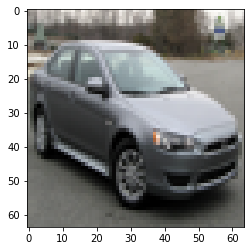

In [7]:
plt.imshow(x_train[8]/2+.5);

In [107]:
def get_optimizer_discriminator():
    return Adam(learning_rate=0.00015, beta_1=0.4)
def get_optimizer_gan():
    return Adam(learning_rate=0.00015, beta_1=0.5)

In [163]:
gen_l1 = 0.00001
gen_l2 = 0.000005
dis_l1 = 0.000004
dis_l2 = 0.000003

In [164]:
def get_generator():
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=random_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
#     model.add(Dropout(0.1))
    
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.1))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (1,1), strides=(1,1), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))

    
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))

    
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))

    
    model.add(Conv2D(3, (1,1), activation='tanh', padding='valid', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
    return model


def get_discriminator(optimizer):
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2), input_shape=[64, 64, 3]))
    model.add(LeakyReLU(alpha=0.25))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(160, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(380, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(512, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
#     model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(1200, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.5))
#     model.add(MaxPool2D())

    model.add(Flatten())
    
    model.add(Dense(512, kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    
    model.add(Dense(128, kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [165]:
get_generator().summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 4096)              249856    
_________________________________________________________________
leaky_re_lu_232 (LeakyReLU)  (None, 4096)              0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_64 (Conv2DT (None, 8, 8, 256)         1048832   
_________________________________________________________________
leaky_re_lu_233 (LeakyReLU)  (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_65 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_234 (LeakyReLU)  (None, 16, 16, 128)     

In [166]:
get_discriminator(Adam()).summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 62, 62, 64)        1792      
_________________________________________________________________
leaky_re_lu_238 (LeakyReLU)  (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 31, 31, 128)       73856     
_________________________________________________________________
leaky_re_lu_239 (LeakyReLU)  (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 31, 31, 128)     

In [167]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    # Вход модели - многомерный гауссовский шум
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    # Выход модели - выход дискриминатора
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [168]:
# Визуализация и сохранение в файл
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(16, 16)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images / 2 + 0.5

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.axis('off')
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    filename = 'generated_a_large_e%03d.png' % epoch
    plt.savefig(filename)
    plt.close()


In [169]:
# Построение модели GAN
generator = get_generator()
optimizer_discriminator = get_optimizer_discriminator()
discriminator = get_discriminator(optimizer_discriminator)
optimizer_gan = get_optimizer_gan()
gan = get_gan_network(discriminator, random_dim, generator, optimizer_gan)

In [ ]:
def train(epochs=1, batch_size=128):
    batch_count = int(x_train.shape[0] / batch_size)
    history_gen = []
    history_dis = []
    with trange(1, epochs + 1, unit="epoch") as pbar:
        for e in pbar:
            for j in range(batch_count):
                # Генерируем случайный набор входного шума и изображений 
                noise = np.random.normal(0, 1, size=[batch_size, random_dim])
                image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

                # Генерируем фейковые изображения
                generated_images = generator.predict(noise)
                X = np.concatenate([image_batch, generated_images])

                # Метки для настоящих изображений (0.95) и фейковых (.05)
                y_dis = np.zeros(2 * batch_size) + .05
                y_dis[:batch_size] = 0.95
                # Добавление небольшого шума в метки
                y_dis += 0.05 * np.random.random(y_dis.shape)

                # Шаг обучения дискриминатора на мини-пакете
                discriminator.trainable = True
                history_dis += [discriminator.train_on_batch(X, y_dis)[0]]

                # Шаг обучения генератора на мини-пакете
                discriminator.trainable = False
                noise = np.random.normal(0, 1, size=[batch_size, random_dim])
                y_gen = np.ones(batch_size)
                gen_loss = gan.train_on_batch(noise, y_gen)
                history_gen += [gen_loss]

                pbar.set_description(f'Generator loss: {round(gen_loss, 3)}.  Discriminator loss: {round(history_dis[-1], 3)}')

            if e % 5 == 0:
                plot_generated_images(e, generator)
    return history_gen, history_dis

train_results = train(200, 64)

Generator loss: 2.129.  Discriminator loss: 0.941:   4%|▍         | 9/200 [06:41<2:20:33, 44.16s/epoch]

In [90]:
# generator.save("generator.h5")
# generator = models.load_model('generator.h5')

In [91]:
# discriminator.save("discriminator.h5")
# discriminator = models.load_model('discriminator.h5')

In [92]:
# gan.save("gan.h5")
# gan = models.load_model('gan.h5')

In [93]:
# discriminator.compile(loss='binary_crossentropy', optimizer=get_optimizer_discriminator(), metrics=['accuracy'])
# gan.compile(loss='binary_crossentropy', optimizer=get_optimizer_gan())

In [ ]:
train_results = train(100, 64)

Generator loss: 2.68.  Discriminator loss: 0.603:  12%|█▏        | 12/100 [09:30<1:04:42, 44.11s/epoch] 

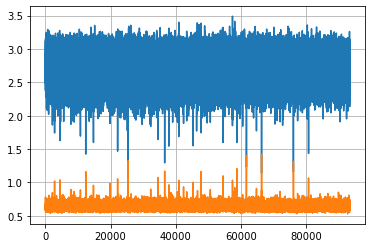

In [174]:
plt.plot(train_results[0][7500:])
plt.plot(train_results[1][7500:])
plt.grid(True)
plt.show()

In [19]:
def show_generated_image(epoch_number):
    plt.figure(figsize=(22, 22))
    plt.axis('off')
    plt.imshow(Image.open(f'generated_a_large_e{epoch_number}.png').crop((150, 130, 850, 830)), aspect=.75);

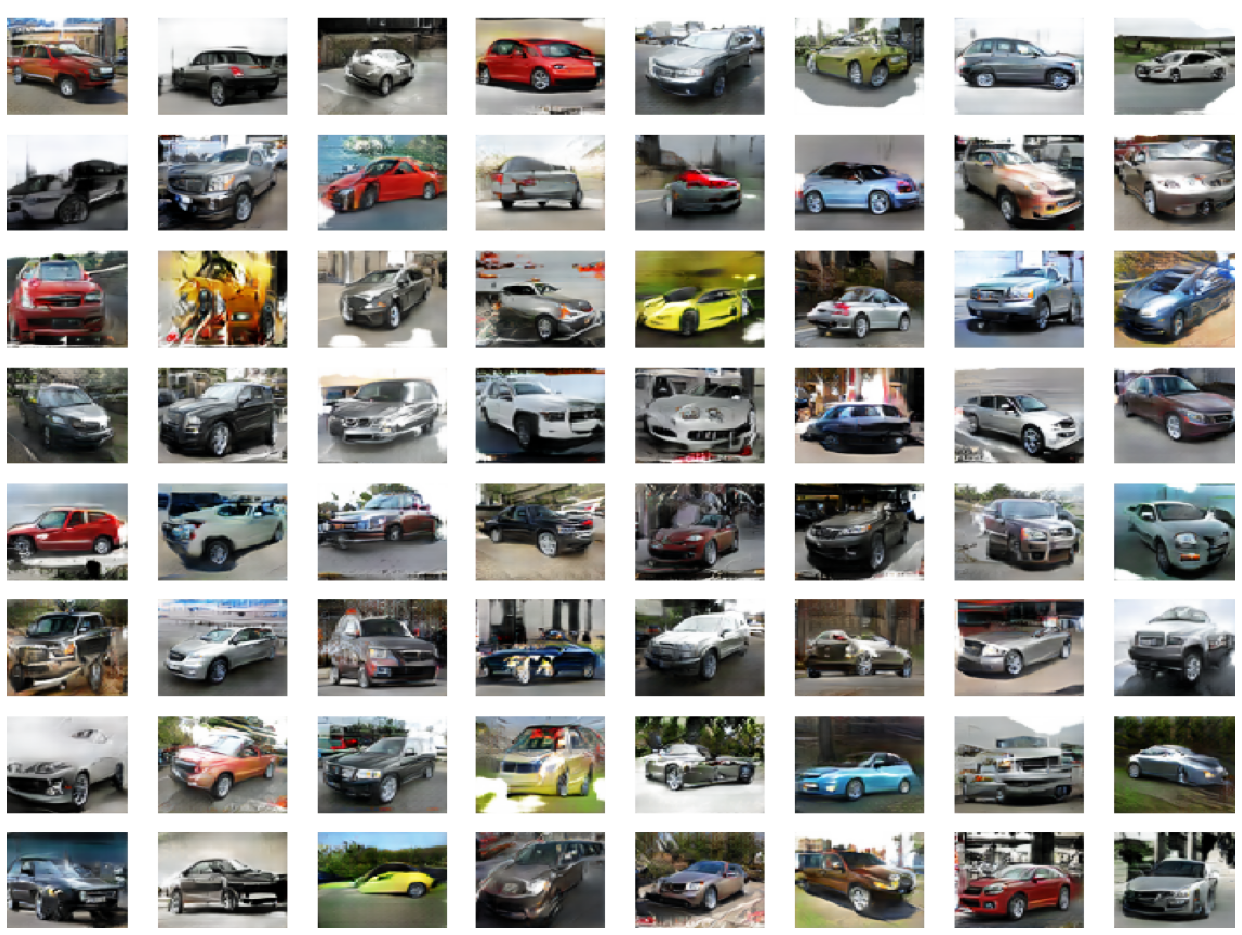

In [182]:
show_generated_image('395')

Визуализация латентного пространства

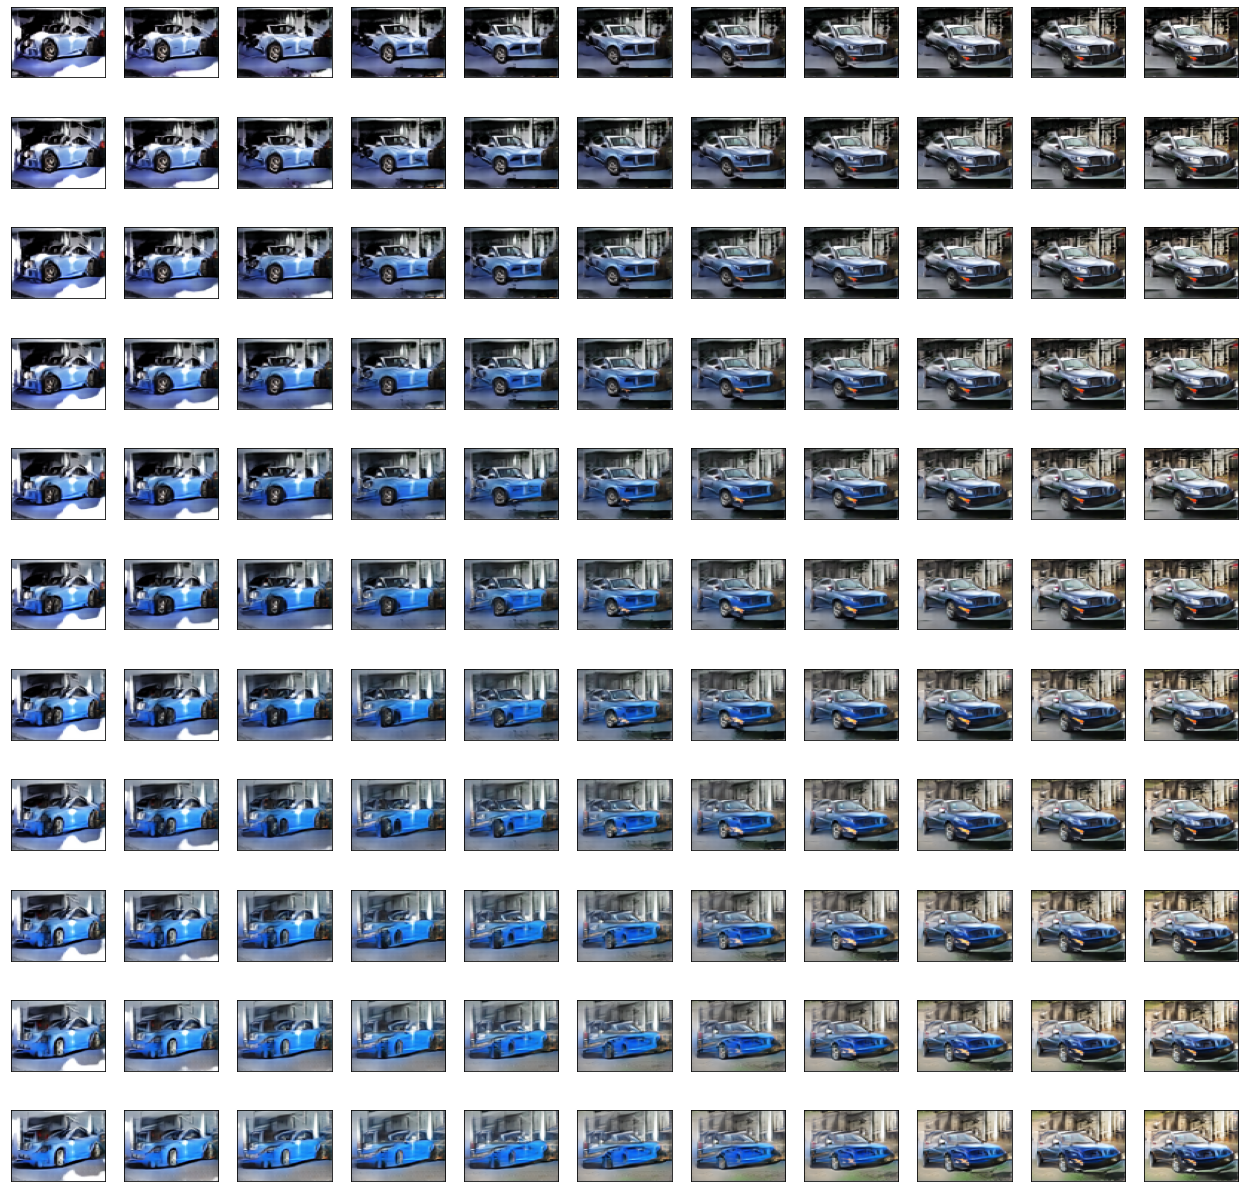

In [129]:
n = 5

plt.figure(figsize=(22, 22))

num = 1
noise = np.random.normal(0, 1, size=58)
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(2*n+1, 2*n+1, num)
        num += 1
        # Можно делать срезы латентного пространства по любым 2 размерностям
        img = generator.predict(np.expand_dims(np.concatenate(([5*i / n, 5*j / n],  noise)), axis=0))
        img = img / 2 + 0.5
        plt.imshow(img[0, :, :], aspect=.75)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()